# Expected Threat (xT)

This notebook demonstrates how to value on-the-ball actions of football players with the xT framework. For an intuitive explanation of how this works, we refer to [Karun’s blog post](https://karun.in/blog/expected-threat.html).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from socceraction import spadl as spadl
from socceraction import xthreat as xthreat

## Load dataset
We will use our dataset with StatsBomb events and corresponding SPADL actions of the Big 5 leagues in 2015/16. The `1.1-load-statsbomb-data` notebook explains how to create this dataset and the `1.2-convert-events-to-actions` notebook adds the SPADL representation of the events.

In [4]:
from pathlib import Path
from socceraction.data import HDFDataset, PartitionIdentifier

data_dir = Path("../../data")

# Open a HDF dataset
dataset = HDFDataset(
    path=(data_dir / "statsbomb-bigfive-1516.h5"), 
    mode="r"
)

First, we load the SPADL dataset and transform the locations of each action such that the lower x-coordinates represent the own half of the team performing the action.

In [5]:
from socceraction.data.transforms import PlayActionsLeftToRight

# Read in all actions of games
df_actions_ltr = dataset.transform(
    PlayActionsLeftToRight(),
    from_table="actions",
    to_table=None,
)

For convenience, we also add the names of action types, bodyparts, results, players and teams.

In [6]:
df_actions_ltr = (
    spadl.add_names(df_actions_ltr)
    .merge(dataset.players(), on=["player_id", "team_id"], how="left")
    .merge(dataset.teams(), on="team_id", how="left")
)

In [7]:
def nice_time(row):
    minute = int(
        row['time_seconds'] // 60
        + (row['period_id'] >= 2) * 45 
        + (row['period_id'] >= 3) * 15 
        + (row['period_id'] == 4) * 15 
    )
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions_ltr['nice_time'] = df_actions_ltr.apply(nice_time, axis=1)

This gives us the following data to work with.

In [8]:
df_actions_ltr.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name,nice_time
0,3879863,819a652e-ec2e-408b-9c40-253c2be88817,1,0.556,228,6994.0,53.33125,33.9575,51.31875,32.2575,0,1,5,0,pass,success,foot_right,Marten de Roon,Atalanta,0m0s
1,3879863,f5af198c-3be1-4430-b067-12423b695e10,1,1.019,228,8420.0,51.31875,32.2575,50.35625,32.2575,21,1,0,1,dribble,success,foot,Luca Cigarini,Atalanta,0m1s
2,3879863,3f4a5604-9133-4782-92ce-3e09dcd39a1e,1,1.424,228,8420.0,50.35625,32.2575,31.01875,28.6025,0,1,5,2,pass,success,foot_right,Luca Cigarini,Atalanta,0m1s
3,3879863,5c219ebd-b5f1-4846-9cf7-ddd942d0ad66,1,2.909,228,6992.0,31.01875,28.6025,32.59375,28.7725,21,1,0,3,dribble,success,foot,Andrea Masiello,Atalanta,0m2s
4,3879863,8a442c77-0c85-4679-8249-6c76a7efca08,1,3.925,228,6992.0,32.59375,28.7725,68.29375,59.3725,0,0,5,4,pass,fail,foot_right,Andrea Masiello,Atalanta,0m3s


## Load pre-trained model

One option is to load a pre-trained xT grid.

In [9]:
# uncomment the lines below if you get an SSLError
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

## Train a custom model

Alternatively, you can train your own model.

In [10]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.train(df_actions_ltr);

**Note:** Instead of first transforming the data, you can also directly train on a dataset.

```python
xTModel.train(dataset, parititions=[...]);
```

## Inspect the xT Model

Extra libraries required: matplotsoccer & plotly

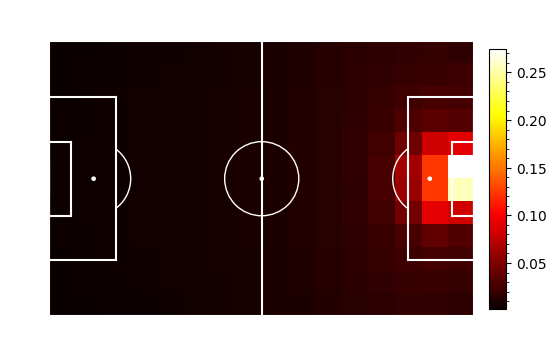

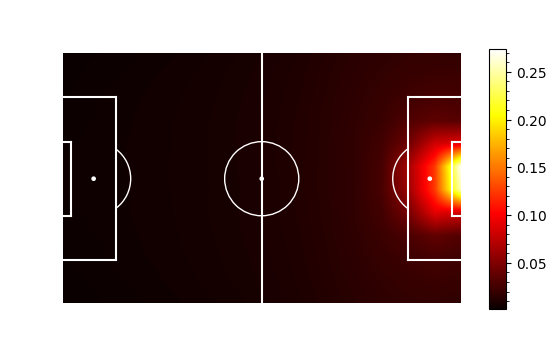

<Axes: >

In [11]:
import matplotsoccer as mps

# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
xx = np.linspace(0, 105, 1050)
yy = np.linspace(0, 68, 680)
X, Y = np.meshgrid(xx, yy, indexing='ij')
mps.heatmap(interp((X, Y)).T, cmap="hot", linecolor="white", cbar="True")

## Compute xT ratings

In [12]:
df_actions_ltr["xT_value"] = xTModel.estimate(df_actions_ltr)
df_actions_ltr[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]].head()

,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,53.33125,33.9575,51.31875,32.2575,-0.001282
1,dribble,51.31875,32.2575,50.35625,32.2575,0.000000
2,pass,50.35625,32.2575,31.01875,28.6025,-0.002541
3,dribble,31.01875,28.6025,32.59375,28.7725,0.000000
4,pass,32.59375,28.7725,68.29375,59.3725,NaN


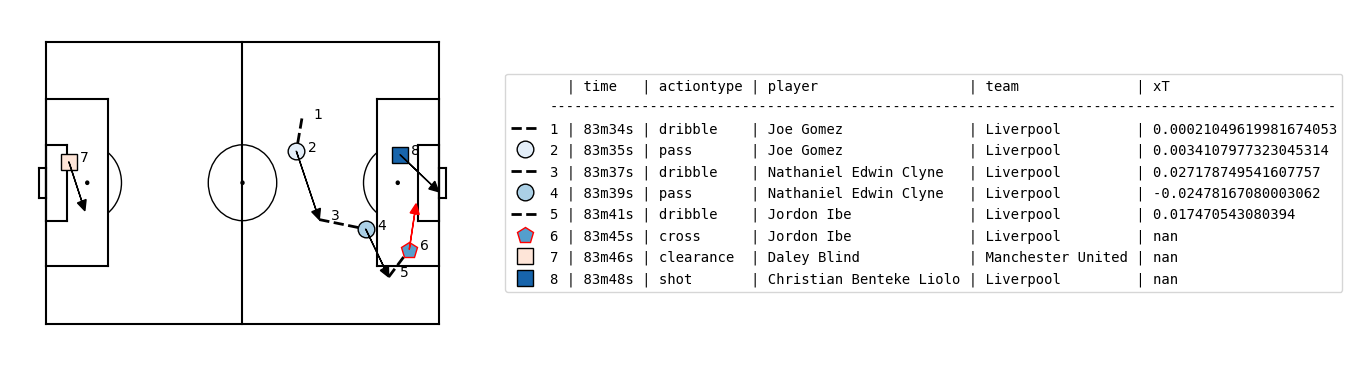

In [13]:
import matplotsoccer

def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'player_name', 'team_name', 'xT_value']],
        labeltitle=['time', 'actiontype', 'player', 'team', 'xT'],
        zoom=False,
        figsize=6)

plot_actions(df_actions_ltr[(df_actions_ltr.game_id == 3754003) & df_actions_ltr.action_id.between(1980, 1987)])

In [14]:
# xT can only be used to value actions that move the ball 
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(df_actions_ltr)

## Rate players

We investigate the ratings per player and look at the quantity-quality trade-off and the rating per player per action type.

In [15]:
df_ranking = (mov_actions[['player_id', 'team_name', 'player_name', 'xT_value']]
    .groupby(['player_id', 'team_name', 'player_name'])
    .agg(xT_count=('xT_value', 'count'), 
         xT_mean=('xT_value', 'mean'),
         xT_sum=('xT_value', 'sum'))
    .sort_values('xT_sum', ascending=False)
    .reset_index()
)

In [16]:
df_ranking.head(10)

,player_id,team_name,player_name,xT_count,xT_mean,xT_sum
0,4320.0,Barcelona,Neymar da Silva Santos Junior,3650,0.003866,14.110538
1,5503.0,Barcelona,Lionel Andrés Messi Cuccittini,3604,0.003323,11.976979
2,3496.0,Arsenal,Mesut Özil,4078,0.002496,10.177671
3,6719.0,Palermo,Franco Damián Vázquez,2936,0.003117,9.152586
4,2995.0,Paris Saint-Germain,Ángel Fabián Di María Hernández,2765,0.003212,8.882087
5,3814.0,Leicester City,Riyad Mahrez,2102,0.003963,8.330662
6,6724.0,Celta Vigo,Manuel Agudo Durán,1990,0.004141,8.241409
7,3831.0,Southampton,Dušan Tadić,1712,0.004803,8.223040
8,5591.0,VfB Stuttgart,Filip Kostić,1534,0.005126,7.862644
9,3385.0,Arsenal,Alexis Alejandro Sánchez Sánchez,2848,0.002739,7.800813


In [17]:
df_minutes_played = (
    dataset.read_table("player_games")[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)
df_minutes_played.head()

,player_id,minutes_played
0,2936,2722
1,2943,1250
2,2944,593
3,2946,2537
4,2947,3500


In [18]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['xT_rating'] = df_ranking_p90['xT_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['xT_count'] * 90 / df_ranking_p90['minutes_played']

In [19]:
MIN_THRESHOLD = 450
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]
df_ranking_p90 = df_ranking_p90.sort_values('xT_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,player_name,xT_count,xT_mean,xT_sum,minutes_played,xT_rating,actions_p90
295,8223.0,Bayern Munich,Franck Bilal Ribéry,949,0.003410,3.236231,712,0.409074,119.957865
0,4320.0,Barcelona,Neymar da Silva Santos Junior,3650,0.003866,14.110538,3148,0.403414,104.351970
4,2995.0,Paris Saint-Germain,Ángel Fabián Di María Hernández,2765,0.003212,8.882087,2082,0.383952,119.524496
1,5503.0,Barcelona,Lionel Andrés Messi Cuccittini,3604,0.003323,11.976979,2818,0.382515,115.102910
34,3726.0,Everton,Gerard Deulofeu Lázaro,1158,0.005359,6.205439,1476,0.378380,70.609756
234,3990.0,Real Madrid,Jesé Rodríguez Ruiz,723,0.004977,3.598091,897,0.361013,72.541806
7,3831.0,Southampton,Dušan Tadić,1712,0.004803,8.223040,2391,0.309525,64.441656
132,5630.0,Napoli,Dries Mertens,1058,0.004091,4.328562,1264,0.308205,75.332278
202,8218.0,Bayern Munich,Arjen Robben,1030,0.003678,3.787875,1113,0.306297,83.288410
612,6725.0,Valencia,Zakaria Bakkali,414,0.004965,2.055606,610,0.303286,61.081967


In the next cell we create a figure to analyze the quantity-quality trade-off. The xT rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings.

/tmp/ipykernel_429194/4135468170.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  xi = [best_player / i for i in yi]


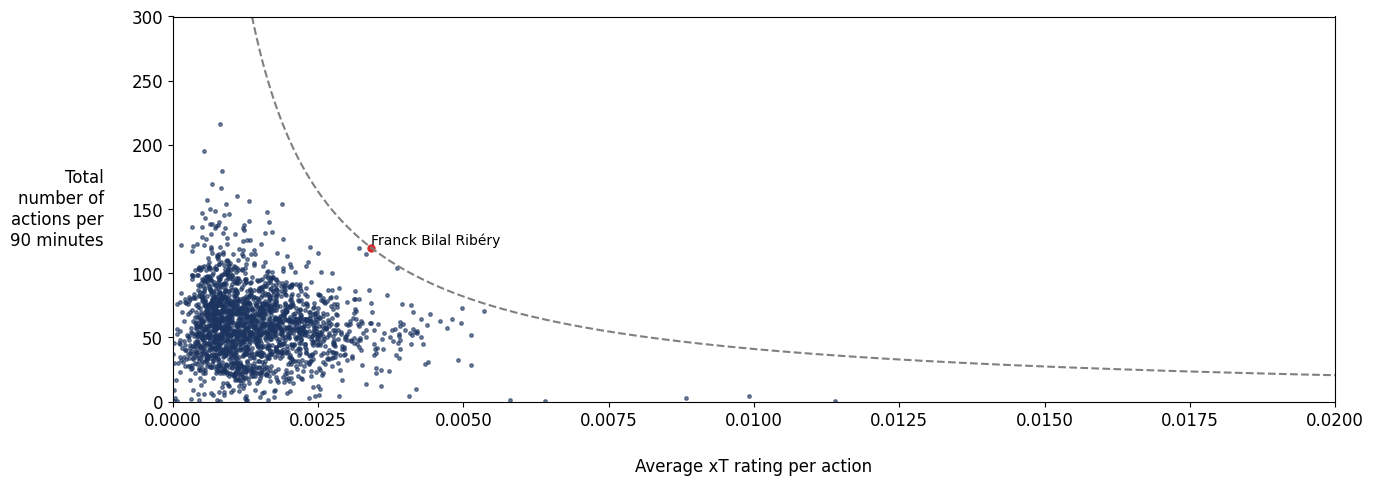

In [20]:
plt.figure(figsize=(15, 5))
x = list(df_ranking_p90['xT_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=5, alpha=.6)

# Plot n best players
n_best = 1
x_best = list(df_ranking_p90['xT_mean'][:n_best])
y_best = list(df_ranking_p90['actions_p90'][:n_best])
names = list(df_ranking_p90['player_name'][:n_best])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=10)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=10, horizontalalignment='left')

best_player = x[0] * y[0]
yi = np.arange(0, 300, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 0.02)
plt.ylim(0, 300)
plt.xlabel('Average xT rating per action', labelpad=20, fontsize=12)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=12)

plt.show()

In the next cells we will analyze the rating per player per action type.

In [21]:
df_rating_action = pd.pivot_table(
    mov_actions, values='xT_value', index=['player_id', 'player_name', 'team_name'],
    columns=['type_name'], aggfunc="sum",
    fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in mov_actions['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [22]:
df_rating_action[df_rating_action['minutes_played'] > MIN_THRESHOLD].sort_values('total', ascending=False).head(10)

,player_id,player_name,team_name,cross,dribble,pass,total,minutes_played
537,4320.0,Neymar da Silva Santos Junior,Barcelona,0.071299,0.228772,0.103343,14.110538,3148
714,5503.0,Lionel Andrés Messi Cuccittini,Barcelona,0.006465,0.149845,0.226206,11.976979,2818
322,3496.0,Mesut Özil,Arsenal,0.115144,0.043159,0.130016,10.177671,3177
957,6719.0,Franco Damián Vázquez,Palermo,0.065067,0.088080,0.095565,9.152586,3312
34,2995.0,Ángel Fabián Di María Hernández,Paris Saint-Germain,0.144483,0.086279,0.153190,8.882087,2082
468,3814.0,Riyad Mahrez,Leicester City,0.068361,0.088186,0.081623,8.330662,3148
961,6724.0,Manuel Agudo Durán,Celta Vigo,0.031272,0.111069,0.145708,8.241409,2575
471,3831.0,Dušan Tadić,Southampton,0.146987,0.068543,0.093994,8.223040,2391
753,5591.0,Filip Kostić,VfB Stuttgart,0.160421,0.065168,0.040341,7.862644,2661
254,3385.0,Alexis Alejandro Sánchez Sánchez,Arsenal,0.070020,0.054695,0.150177,7.800813,2554


In [23]:
dataset.close()